#### Evaluating doc2vec vectors for wiki10 documents (wikipedia article text with multiple class labels)

In [21]:
# import modules & set up logging
from pathlib import Path
import re
import string 
from itertools import islice
import multiprocessing
import json
import numpy as np
import pandas as pd 
from sklearn.manifold import TSNE
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from gensim.models import Doc2Vec

init_notebook_mode(connected=True)

In [4]:
DATA_DIR = Path('../../data/wiki10')
TEXT_DIR = DATA_DIR / 'text' 
TAGS_PATH = DATA_DIR / 'tags.json'
MODEL_PATH = DATA_DIR / 'doc2vec.model'

#### Evaluation

We will now evaluate distance between documents by reducing dimensions with T-SNE and plotting the result. We can also get an idea of how these "clusters" compare to human categorisation by loading our document labels and overlaying.

Loading model and meta data containing tag information

In [6]:
model = Doc2Vec.load(str(MODEL_PATH))

In [7]:
with TAGS_PATH.open() as input_fileobj:
    tags = json.load(input_fileobj) 

Create DataFrame from meta dictionary containing

* id: document filename
* title: wikipedia document title
* user_count: number of people which tagged the document
* tags: dict of {'tag': tag_score} where tag score is the proportion of users which assigned that tag
* tag: single "best" tag with the highest score

In [8]:
meta_records = []
for doc_id in model.docvecs.offset2doctag:
    tags_meta = tags[doc_id]
    tags_meta['id'] = doc_id
    tags_meta['tag'] = max(tags_meta['tags'], key=tags_meta['tags'].get) 
    meta_records.append(tags_meta) 

In [9]:
meta_df = pd.DataFrame.from_records(meta_records)

In [10]:
meta_df.head()

,id,tag,tags,title,user_count
0,33d29682601cfaa391fe7516d90d6baf,food,"{'food': 0.4, 'culture': 0.06666666666666667}",Miso soup,15
1,8346b880e4084563079d7d91f1d745f7,religion,"{'religion': 0.23076923076923078, 'english': 0...",Eucharist,13
2,2843aa22bedb489f593655a9fad428c3,religion,"{'religion': 0.25, 'literature': 0.0625}",Book of Job,16
3,f2f8c58e3424ca8a229133646d94676b,language,{'language': 0.5},Hungarian language,18
4,011847f83eba74ae537e88609355b068,tv,{'tv': 0.4},Undeclared,10


In [11]:
meta_df.tag.value_counts().head(35)

history         1428
music            985
programming      940
science          925
philosophy       712
politics         619
religion         605
psychology       605
art              578
health           565
language         483
books            465
math             449
software         443
security         360
design           355
games            349
economics        347
literature       343
travel           343
linux            315
people           306
technology       305
food             304
culture          293
tv               290
business         272
web              272
physics          264
writing          257
finance          239
movies           234
film             232
architecture     227
statistics       216
Name: tag, dtype: int64

We have too many classes to plot the results clearly, so we will reduce our sample by selecting 10 tag types which are both common, and relatively easy to separate heuristically

In [14]:
top10_tags = {'literature', 'film', 'math', 'music', 'philosophy', 'art', 'programming', 'religion', 'science', 'politics'}
top10_mask = meta_df.tag.isin(top10_tags) 

In [15]:
doc_vectors = model.docvecs.doctag_syn0[top10_mask] 
meta_df = meta_df[top10_mask]

In [16]:
meta_df.tag.value_counts()

music          985
programming    940
science        925
philosophy     712
politics       619
religion       605
art            578
math           449
literature     343
film           232
Name: tag, dtype: int64

In [17]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(doc_vectors)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6388 samples in 0.039s...
[t-SNE] Computed neighbors for 6388 samples in 16.219s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6388
[t-SNE] Computed conditional probabilities for sample 2000 / 6388
[t-SNE] Computed conditional probabilities for sample 3000 / 6388
[t-SNE] Computed conditional probabilities for sample 4000 / 6388
[t-SNE] Computed conditional probabilities for sample 5000 / 6388
[t-SNE] Computed conditional probabilities for sample 6000 / 6388
[t-SNE] Computed conditional probabilities for sample 6388 / 6388
[t-SNE] Mean sigma: 1.292693
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.883591
[t-SNE] Error after 300 iterations: 2.342015


In [18]:
tsne_results

array([[ -5.58689547,  10.09768963],
       [ -5.5191102 ,   9.16908264],
       [  2.5541172 ,   6.44912767],
       ..., 
       [ -6.6437788 ,  -1.33944798],
       [  3.98007703,  -2.59868956],
       [ -2.91864157,  -7.7234478 ]], dtype=float32)

In [144]:
tsne_results

array([[ 7.53753328, -8.70212078],
       [ 7.2559247 , -7.8006506 ],
       [-1.20555341, -6.77294493],
       ..., 
       [ 5.92702579,  2.80291939],
       [-4.38910437,  1.7761054 ],
       [ 1.38827753,  8.24677372]], dtype=float32)

In [26]:
traces = []
for tag_type in common_tags:
    trace = go.Scatter(
        x=tsne_results[meta_df.tag==tag_type,0],
        y=tsne_results[meta_df.tag==tag_type,1],
        mode='markers',
        name=tag_type, 
        marker=dict(
            size=5,
            opacity=0.5
        )
    )
    traces.append(trace)

fig = go.Figure(data=traces)

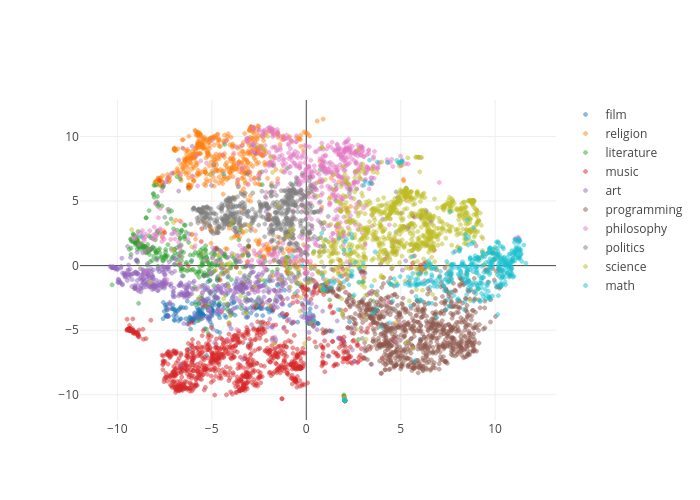

In [27]:
py.image.ishow(fig)